# Klasifikasi Gambar Kue Tradisional
- **Deskripsi** : Membuat model untuk klasifikasi gambar dengan arsitektur Mobilenetv2 + Feature Extraction untuk main feature pada proyek aplikasi berbasis web yaitu NusaKue
- **Group ID** : CC25-CF222
- **Nama Anggota MC** :
  - Fiyanda Ma'muri
  - Ady Subagya Junior
  - Bagus Dzakiy Rahman Saputra


## Import Library

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import json

## Import Datasets

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
image_data = 'datasets-kue-tradisional'

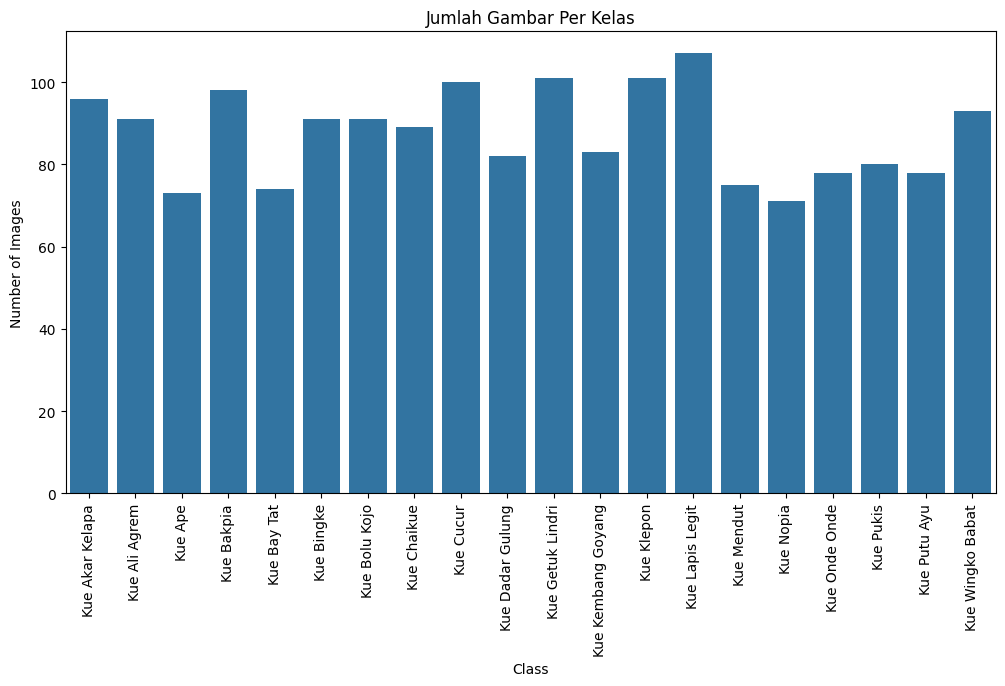

In [3]:
# Menghitung jumlah gambar di setiap kelas (folder)
class_counts = []
class_names = []

for class_name in os.listdir(image_data):
    class_path = os.path.join(image_data, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya membaca folder
        num_images = len(os.listdir(class_path))
        class_counts.append(num_images)
        class_names.append(class_name)

# Membuat DataFrame
df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Visualisasi dengan seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Count", data=df)
plt.xticks(rotation=90)  # Rotasi label agar tidak tumpang tindih
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Jumlah Gambar Per Kelas")
plt.show()

In [4]:
df

,Class,Count
0,Kue Akar Kelapa,96
1,Kue Ali Agrem,91
2,Kue Ape,73
3,Kue Bakpia,98
4,Kue Bay Tat,74
5,Kue Bingke,91
6,Kue Bolu Kojo,91
7,Kue Chaikue,89
8,Kue Cucur,100
9,Kue Dadar Gulung,82


## Spliting Data

In [5]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15):
    """
    Membagi dataset ke dalam folder Train, Validation, dan Test menggunakan train_test_split dari sklearn.

    Parameters:
    source_dir (str): Path dataset asli.
    train_dir (str): Path untuk dataset training.
    val_dir (str): Path untuk dataset validation.
    test_dir (str): Path untuk dataset testing.
    train_ratio (float): Proporsi data untuk training.
    val_ratio (float): Proporsi data untuk validation.
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    test_ratio = 1.0 - (train_ratio + val_ratio)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]

        # Split train dan sisa
        train_images, temp_images = train_test_split(
            images, test_size=(1 - train_ratio), random_state=42, shuffle=True
        )

        # Split sisa menjadi val dan test
        val_relative_ratio = val_ratio / (val_ratio + test_ratio)
        val_images, test_images = train_test_split(
            temp_images, test_size=(1 - val_relative_ratio), random_state=42, shuffle=True
        )

        for dataset_dir, dataset_images in zip([train_dir, val_dir, test_dir],
                                               [train_images, val_images, test_images]):
            class_dest = os.path.join(dataset_dir, class_name)
            os.makedirs(class_dest, exist_ok=True)

            for img in dataset_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(class_dest, img))

# Path dataset asli dan tujuan
source_dataset = "datasets-kue-tradisional"
train_dataset = "datasets/Train"
val_dataset = "datasets/Validation"
test_dataset = "datasets/Test"

# Jalankan fungsi split
split_dataset(source_dataset, train_dataset, val_dataset, test_dataset)


## Pre-processing Data

In [6]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder yang telah dibagi
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 1215 images belonging to 20 classes.
Found 254 images belonging to 20 classes.
Found 283 images belonging to 20 classes.


## Modelling

In [7]:
# Memuat model MobileNetV2 tanpa fully connected layers (include_top=False)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Membekukan semua lapisan MobileNetV2 agar tidak dilatih ulang
base_model.trainable = False

# Membuat model baru dengan lapisan tambahan (feature extraction)
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])


# Menyusun model dengan optimizer, loss function, dan metrik evaluasi
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Menampilkan ringkasan model
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [8]:
# Custom Callback untuk menghentikan training jika akurasi ≥ 86%
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:
            print(f"\nTraining dihentikan karena akurasi telah mencapai {logs.get('accuracy'):.2f}")
            self.model.stop_training = True

# Callbacks untuk optimasi training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.90)

In [9]:
# Melakukan training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), StopAtAccuracy()]
)

Epoch 1/50


76/76 [==============================] - 48s 599ms/step - loss: 3.3936 - accuracy: 0.0872 - precision: 0.1019 - recall: 0.0091 - val_loss: 2.7242 - val_accuracy: 0.1614 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
76/76 [==============================] - 33s 428ms/step - loss: 2.7426 - accuracy: 0.1720 - precision: 0.6875 - recall: 0.0181 - val_loss: 2.4030 - val_accuracy: 0.3031 - val_precision: 1.0000 - val_recall: 0.0197
Epoch 3/50
76/76 [==============================] - 33s 432ms/step - loss: 2.5002 - accuracy: 0.2280 - precision: 0.6750 - recall: 0.0444 - val_loss: 2.1621 - val_accuracy: 0.3583 - val_precision: 0.9583 - val_recall: 0.0906
Epoch 4/50
76/76 [==============================] - 33s 441ms/step - loss: 2.2918 - accuracy: 0.2823 - precision: 0.6890 - recall: 0.0930 - val_loss: 1.9276 - val_accuracy: 0.4055 - val_precision: 0.9348 - val_recall: 0.1693
Epoch 5/50
76/76 [==============================] - 32s 421ms/step - loss: 2.0418 - accura

## Evaluation

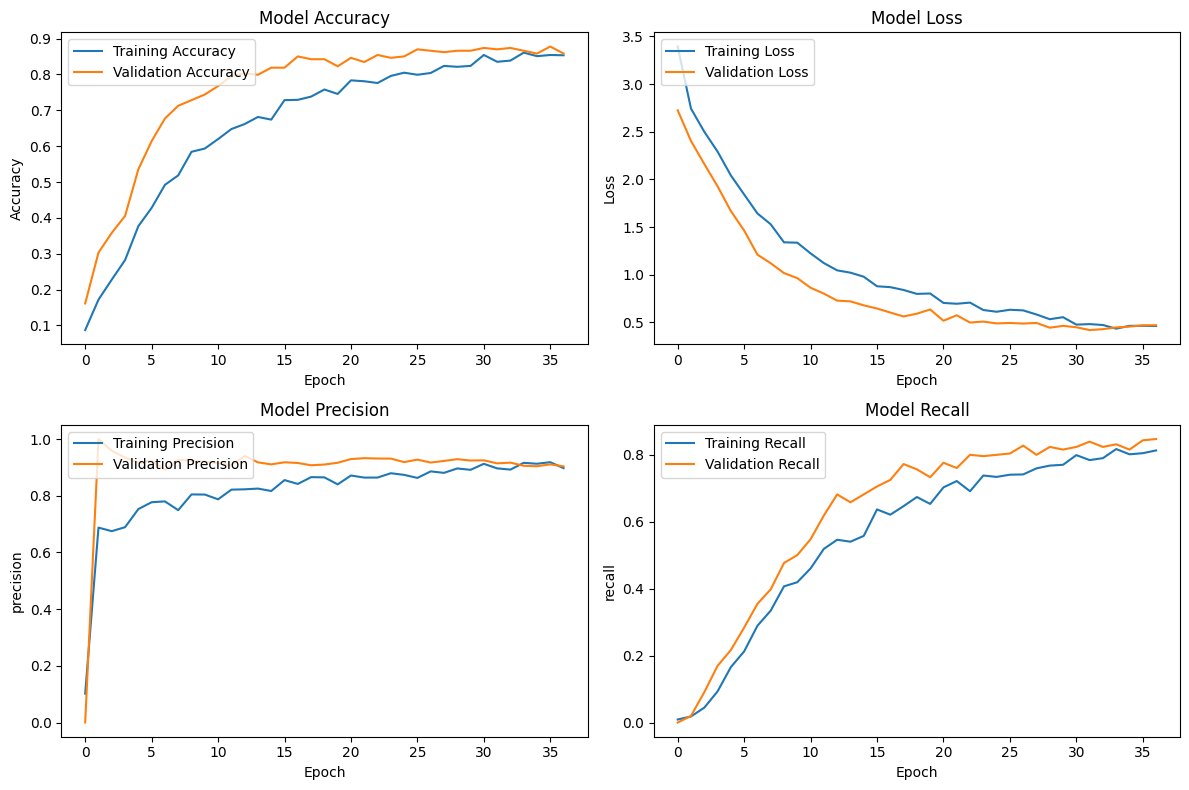

In [11]:
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 265ms/step


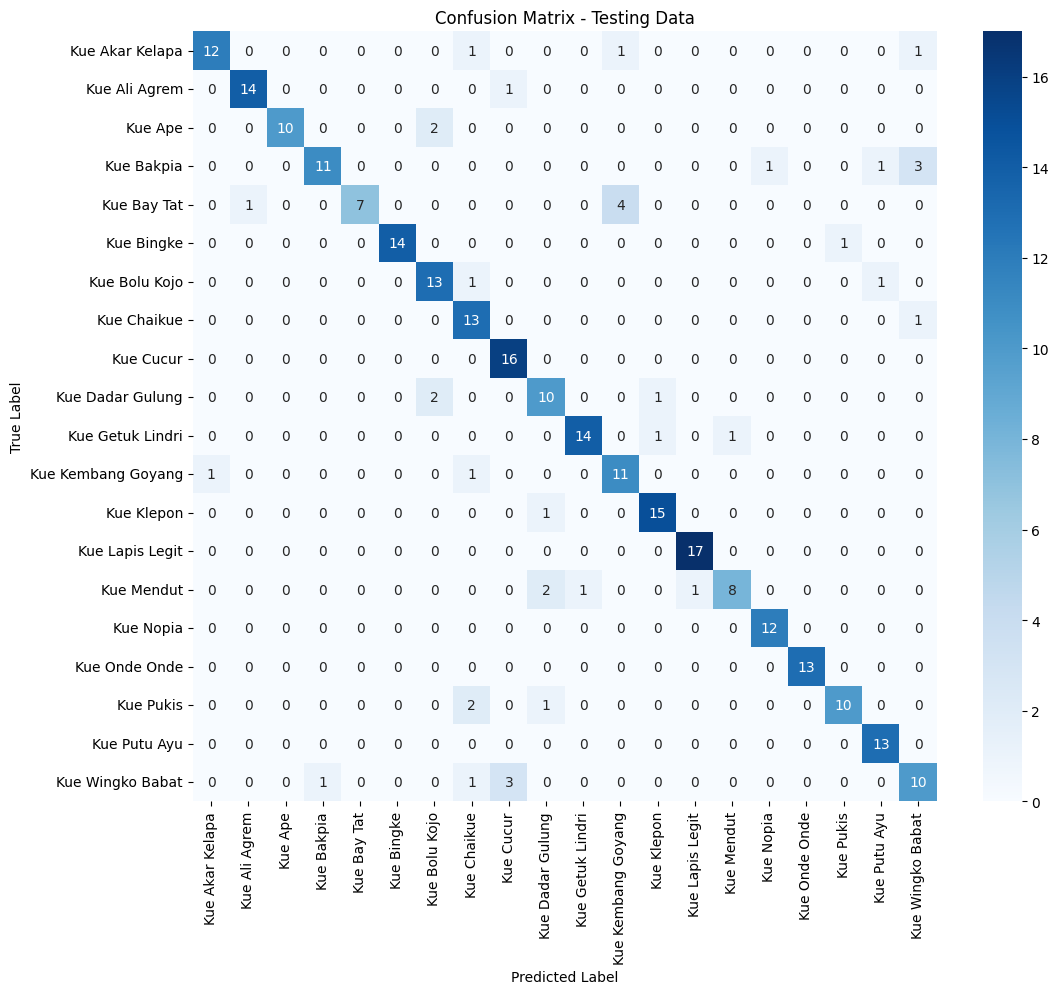


Classification Report (Data Testing):
                    precision    recall  f1-score   support

   Kue Akar Kelapa       0.92      0.80      0.86        15
     Kue Ali Agrem       0.93      0.93      0.93        15
           Kue Ape       1.00      0.83      0.91        12
        Kue Bakpia       0.92      0.69      0.79        16
       Kue Bay Tat       1.00      0.58      0.74        12
        Kue Bingke       1.00      0.93      0.97        15
     Kue Bolu Kojo       0.76      0.87      0.81        15
       Kue Chaikue       0.68      0.93      0.79        14
         Kue Cucur       0.80      1.00      0.89        16
  Kue Dadar Gulung       0.71      0.77      0.74        13
  Kue Getuk Lindri       0.93      0.88      0.90        16
Kue Kembang Goyang       0.69      0.85      0.76        13
        Kue Klepon       0.88      0.94      0.91        16
   Kue Lapis Legit       0.94      1.00      0.97        17
        Kue Mendut       0.89      0.67      0.76        12


In [12]:
# Mendapatkan label kelas dari generator
class_labels = list(train_generator.class_indices.keys())

# Mengambil semua gambar dari test set
y_true = []
y_pred = []

# Looping melalui seluruh test dataset
for images, labels in test_generator:
    predictions = model.predict(images)  # Prediksi model
    y_true.extend(np.argmax(labels, axis=1))  # Label sebenarnya
    y_pred.extend(np.argmax(predictions, axis=1))  # Label prediksi

    if len(y_true) >= test_generator.samples:
        break  # Hentikan setelah seluruh dataset diuji

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Testing Data')
plt.show()

# Menampilkan Classification Report
print("\nClassification Report (Data Testing):")
print(classification_report(y_true, y_pred, target_names=class_labels))


## Pre-Deployment

In [13]:
# format .h5
model.save("model.h5")

c:\Users\fiyan\Documents\DBS CODING CAMP\CAPSTONE\analisis\imagevenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Simpan class_indices ke file JSON
with open("labels.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Labels berhasil disimpan!")